In [1]:
import sys
import os
# Disable gpu
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  

import numpy as np
from mxnetnet import MXNetNet
from pytorchnet import PytorchNet
from tfnet import TFNet

/kuacc/users/ccengiz17/.anaconda3/envs/dl_frameworks/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


In [2]:
print("OS: ", sys.platform)
print("Python: ", sys.version)

OS:  linux
Python:  3.6.8 |Anaconda custom (64-bit)| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]


In [3]:
class ConvBenchmark:
    def __init__(self, **bench_args):
        convweights = bench_args["convweights"]
        self.conv_filters_ = []
        for w in convweights:
            w_array = np.random.random(w).astype(np.float32)
            self.conv_filters_.append(w_array)        
        
        if "poolings" in bench_args:
            self.poolings_ = bench_args["poolings"]
        else:
            self.poolings_ = False
        
        self.networks_ = {}
        self.networks_["pytorch_CNN"] = PytorchNet(self.conv_filters_, self.poolings_)
        self.networks_["TF_CNN"] = TFNet(self.conv_filters_, self.poolings_)
        self.networks_["MXNet_CNN"] = MXNetNet(self.conv_filters_, self.poolings_)
        
        self.input_ = np.random.random(bench_args["inputsize"]).astype(np.float32)
        self.results_ = {}
        self.printOut_ = False
        if "printOut" in bench_args:
            self.printOut_ = bench_args["printOut"]
        
    def runNetworks(self):
        # Pytorch nn.Conv2d takes input a 4D Tensor of [nSamples x nChannels x Height x Width]
        # Input is defined in Pytorch layout fashion
        for netname, network in self.networks_.items():
            output, t = network.forward(np.copy(self.input_))
            self.results_[netname] = {"output": output, "runtime": t}
            if self.printOut_:
                print("{} took {:.5} seconds.".format(netname, t))
            

In [4]:
# input is a 4D Tensor of [nSamples x nChannels x Height x Width]
inBS, inCh, inHeight, inWidth = (256,3,32,32)
inputsize = inBS, inCh, inHeight, inWidth

# Filters are 4D tensor in form [out_channels, in_channels, fil_height, fil_width]
conv1w = (256, 3, 3, 3)
conv2w = (512, 256, 3, 3)
convweights = (conv1w, conv2w)
poolings = (2,2)

benchmark = ConvBenchmark(inputsize=inputsize, convweights=convweights, poolings=poolings, printOut="True")
benchmark.runNetworks()
print("\nResults of re-running after cold start:")
benchmark.runNetworks()

pytorch_CNN took 3.8104 seconds.
TF_CNN took 0.073271 seconds.
MXNet_CNN took 0.0036876 seconds.

Results of re-running after cold start:
pytorch_CNN took 3.0718 seconds.
TF_CNN took 0.050487 seconds.
MXNet_CNN took 0.00076294 seconds.


In [5]:
pytorch_out = benchmark.results_["pytorch_CNN"]["output"]
mxnet_out = benchmark.results_["MXNet_CNN"]["output"]
tf_out = benchmark.results_["TF_CNN"]["output"]

print(pytorch_out.shape)
print(type(pytorch_out))
print(mxnet_out.shape)
print(type(mxnet_out))
print(tf_out.shape)
print(type(tf_out))

(256, 512, 6, 6)
<class 'numpy.ndarray'>
(256, 512, 6, 6)
<class 'numpy.ndarray'>
(256, 512, 6, 6)
<class 'numpy.ndarray'>


In [6]:
print(pytorch_out[0,0,0:2,0:2], "\n")
print(mxnet_out[0,0,0:2,0:2], "\n")
print(tf_out[0,0,0:2,0:2], "\n")

[[ 8819.92382812  8624.03808594]
 [ 9147.15917969  8946.125     ]] 

[[ 8819.92382812  8624.03808594]
 [ 9147.15917969  8946.125     ]] 

[[ 8819.9375      8624.03417969]
 [ 9147.14550781  8946.12402344]] 



In [7]:
print(np.isclose(mxnet_out, pytorch_out, atol=0.001).all())
print(np.isclose(mxnet_out, tf_out, atol=0.001).all())
print(np.isclose(tf_out, pytorch_out, atol=0.001).all())

True
True
True


In [8]:
# delete previous benchmark data to save up space
for i in (pytorch_out, mxnet_out, tf_out, benchmark):
    del i

In [9]:
## Plot comparisons for inputs having different spatial dimensions and batch sizes
import matplotlib.pyplot as plt

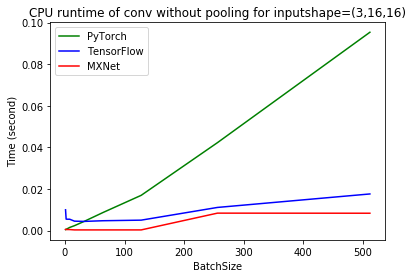

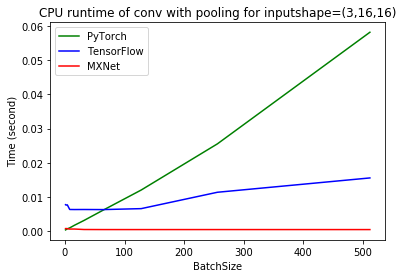

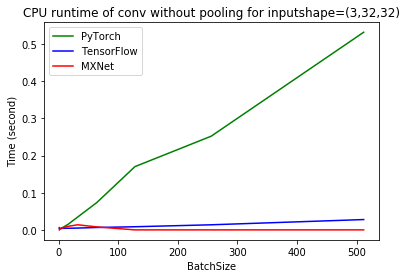

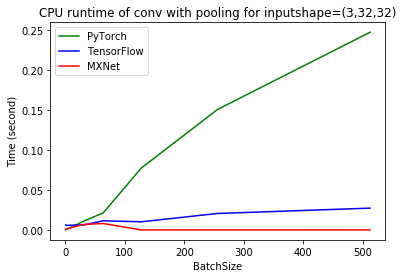

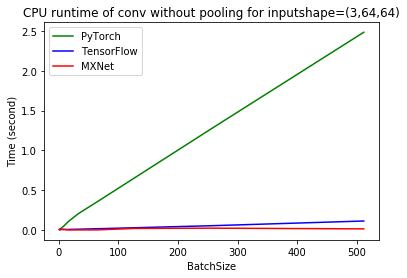

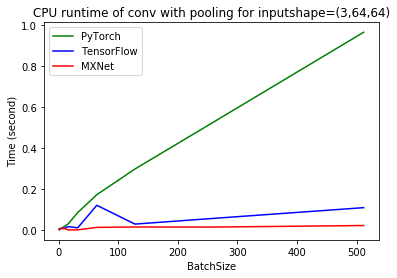

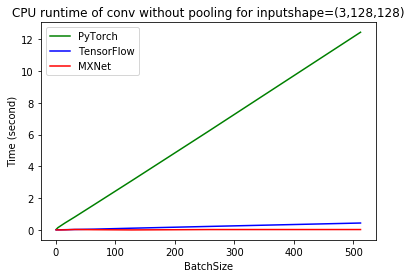

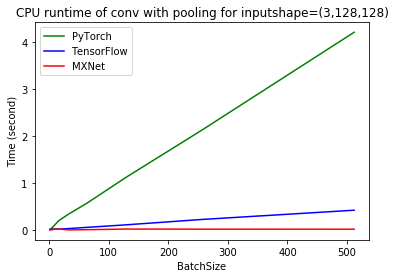

In [10]:
# input is a 4D Tensor of [nSamples x nChannels x Height x Width]
# Filters are 4D tensor in form [out_channels, in_channels, fil_height, fil_width]
for j in range(4,8):
    in_spat_dim = (2**j, 2**j)
    poolings = (2,2)
    conv1w = (16, 3, 5, 5)
    conv2w = (64, 16, 5, 5)
    convweights = (conv1w, conv2w)
    in_ch = conv1w[1]
    runtimes_no_pool = {"inputshape":(in_ch, *in_spat_dim), "bs_array":[], "pytorch_CNN":[], "MXNet_CNN":[], "TF_CNN":[]}
    runtimes_with_pool = {"inputshape":(in_ch, *in_spat_dim), "bs_array":[], "pytorch_CNN":[], "MXNet_CNN":[], "TF_CNN":[]}
    for i in range(10):
        bs = 2**i
        runtimes_no_pool["bs_array"].append(bs)
        runtimes_with_pool["bs_array"].append(bs)
        inputshape = (bs, in_ch, *in_spat_dim)
    
        benchmark_no_pool = ConvBenchmark(inputsize=inputshape, convweights=convweights)
        benchmark_no_pool.runNetworks() # cold start
        benchmark_no_pool.runNetworks()
        for cnn_name in ("pytorch_CNN", "MXNet_CNN", "TF_CNN"):
            runtimes_no_pool[cnn_name].append(benchmark_no_pool.results_[cnn_name]["runtime"])
    
        benchmark_with_pool = ConvBenchmark(inputsize=inputshape, convweights=convweights, poolings=poolings)
        benchmark_with_pool.runNetworks() # cold start
        benchmark_with_pool.runNetworks()
        for cnn_name in ("pytorch_CNN", "MXNet_CNN", "TF_CNN"):
            runtimes_with_pool[cnn_name].append(benchmark_with_pool.results_[cnn_name]["runtime"])
            
            
    plt.figure(2*j-7)
    pytorch_plt, = plt.plot(runtimes_no_pool["bs_array"], runtimes_no_pool["pytorch_CNN"], 'g-')
    tf_plt, = plt.plot(runtimes_no_pool["bs_array"], runtimes_no_pool["TF_CNN"], 'b-')
    mxnet_plt, = plt.plot(runtimes_no_pool["bs_array"], runtimes_no_pool["MXNet_CNN"], '-r')
    plt.legend([pytorch_plt, tf_plt, mxnet_plt], ["PyTorch", "TensorFlow", "MXNet"])
    plt.xlabel('BatchSize')
    plt.ylabel('Time (second)')
    in_ch, in_H, in_W = runtimes_no_pool["inputshape"]
    plt.title('CPU runtime of conv without pooling for inputshape=({},{},{})'.format(in_ch, in_H, in_W))
    plt.savefig('./figures/figure{}.png'.format(2*j-7))
    plt.show(block=False)

    plt.figure(2*j-6)
    pytorch_plt, = plt.plot(runtimes_with_pool["bs_array"], runtimes_with_pool["pytorch_CNN"], 'g-')
    tf_plt, = plt.plot(runtimes_with_pool["bs_array"], runtimes_with_pool["TF_CNN"], 'b-')
    mxnet_plt, = plt.plot(runtimes_with_pool["bs_array"], runtimes_with_pool["MXNet_CNN"], '-r')
    plt.legend([pytorch_plt, tf_plt, mxnet_plt], ["PyTorch", "TensorFlow", "MXNet"])
    plt.xlabel('BatchSize')
    plt.ylabel('Time (second)')
    in_ch, in_H, in_W = runtimes_with_pool["inputshape"]
    plt.title('CPU runtime of conv with pooling for inputshape=({},{},{})'.format(in_ch, in_H, in_W))
    plt.savefig('./figures/figure{}.png'.format(2*j-6))
    plt.show(block=False)